## Projeto

Esse projeto em PySpark faz uma análise de dados de preços de combustíveis da ANP, reproduzindo trabalho anterior desenvolvido com Hadoop e Hive.

- https://github.com/pinei/hadoop-precos-combustiveis

## Coleta de dados

O trabalho faz uso de dados publicados pela ANP (Agência Nacional de Petróleo)

> Em cumprimento às determinações da Lei do Petróleo (Lei nº 9478/1997, artigo 8º), a ANP acompanha os preços praticados por revendedores de combustíveis automotivos e de gás liquefeito de petróleo envasilhado em botijões de 13 quilos (GLP P13), por meio de uma pesquisa semanal de preços realizada por empresa contratada.

- [Série Histórica de Preços de Combustíveis e de GLP](https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/serie-historica-de-precos-de-combustiveis)

Coletamos a série histórica de "Combustíveis automotivos" que vai de 2004 a 2023. São 39 arquivos CSV totalizando aproximadamente 3.7 GB.

![Amostra dos dados](./assets/amostra_planilha_revenda.png)

- [Metadados em PDF](https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/metadados-serie-historica-precos-combustiveis-1.pdf)

Temos as seguintes colunas nos arquivos CSV, em conformidade com a documentação de metadados:

| Coluna            | Tipo    | Comentário                                                                           |
| ----------------- | ------- | ------------------------------------------------------------------------------------ |
| Regiao            | Texto   | Sigla da região do país (ex: S, N, SE)                                               |
| Estado            | Texto   | Sigla de unidade federativa (ex: RJ, SP, MG)                                         |
| Municipio         | Texto   | Nome de município                                                                    |
| Revenda           | Texto   | Razão social do revendedor de combustível                                            |
| CNPJ da Revenda   | Texto   | CNPJ do revendedor                                                                   |
| Nome da Rua       | Texto   | Logradouro                                                                           |
| Numero Rua        | Texto   | Logradouro                                                                           |
| Complemento       | Texto   | Logradouro                                                                           |
| Bairro            | Texto   | Logradouro                                                                           |
| CEP               | Texto   | Código de Endereçamento Postal                                                       |
| Produto           | Texto   | Produto combustível (ex: GASOLINA, ETANOL, DIESEL)                                   |
| Data da Coleta    | Data    | Data da pesquisa de preço (formato dd/mm/aaaa)                                       |
| Valor de Venda    | Decimal | Valor de venda da unidade de combustível (4 casas decimais, vírgula como separador)  |
| Valor de Compra   | Decimal | Valor de compra da unidade de combustível (4 casas decimais, virgula como separador) |
| Unidade de Medida | Texto   | Unidade ao qual os valores de compra e venda se referem (ex: R$ / litro)             |
| Bandeira          | Texto   | Nome de marca do posto de revenda (ex: IPIRANGA, BRANCA, COSAN, etc.)                |


## Infraestrutura

Aproveitando a configuração de cluster da Google Cloud Platform criada para o [projeto Hadoop](https://github.com/pinei/hadoop-precos-combustiveis), incluímos o JupyterLab para trabalhar com o PySpark.

![cluster-info](./assets/cluster_info.png)

O suporte ao Hive precisa de um bucket para funcionar em modo distribuído. O caminho para o bucket pode ser especificado em uma propriedade do cluster, antes da sua criação, conforme exemplo:

```
spark:spark.sql.warehouse.dir=gs://hadoop-stage/spark-warehouse
```

Em paralelo usamos uma instalação em Raspberry Pi 4 para verificar a viabilidade e desempenho nesse tipo de hardware de baixo custo.

- [Running PySpark in JupyterLab on a Raspberry Pi](https://dev.to/pinei/running-pyspark-in-jupyterlab-on-a-raspberry-pi-1293)

Por rodar no modo standalone, vamos chamar este ambiente de "máquina local".

Em projeto anterior os arquivos CSV foram organizados em um bucket do Google Cloud Storage.

> `https://console.cloud.google.com/storage/browser/hadoop-dados-brutos`

No cluster Dataproc o Spark tem acesso padrão aos arquivos desse storage via URL `gs://hadoop-dados-brutos`, podendo inclusive fazer o processamento distribuído entre os nós.

In [7]:
DATA_PATH = 'gs://hadoop-dados-brutos'

No Spark em máquina local, o suporte a conexão com o mesmo storage precisa de configuração adicional.

- [How to fix "No FileSystem for scheme: gs" in pyspark?](https://stackoverflow.com/questions/55595263/how-to-fix-no-filesystem-for-scheme-gs-in-pyspark)

## Iniciando a sessão do Spark

Inicializamos uma sessão do Spark com suporte ao Hive para gerenciamento de metadados das bases de dados.

Também habilitamos o suporte ao sistema de arquivos do Google Cloud (para rodar em máquina local).

In [1]:
from pyspark.sql import SparkSession

spark = ( SparkSession
    .builder
    .appName("analise-dados")
    .config("spark.jars", "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar")
    .enableHiveSupport()
    .getOrCreate() )

spark._jsc.hadoopConfiguration().set('fs.gs.impl', 'com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem')

23/10/14 06:26:27 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Quando executando fora da Google Cloud, o conector do Google precisa de uma chave para autenticação no serviço.

Passo a passo para gerar a chave:
- Console do Google Cloud Platform
- APIs e Serviços > Credenciais
- Criar Conta de Serviço
- Criar Chave do tipo JSON

> "É feito o download de um arquivo contendo a chave privada. Armazene o arquivo com segurança porque essa chave não pode ser recuperada em caso de perda."

Subimos o arquivo JSON para uma pasta de trabalho:

> `/home/aldinei_bastos/work/seventh-abacus-395221-52fc140a5609.json`

É necessário então localizar o JSON através de uma variável de ambiente `GOOGLE_APPLICATION_CREDENTIALS`

In [3]:
import os

HOME_DIR = os.environ["HOME"]
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = f'{HOME_DIR}/work/seventh-abacus-395221-52fc140a5609.json'

In [2]:
spark.catalog.listDatabases()

ivysettings.xml file not found in HIVE_HOME or HIVE_CONF_DIR,/etc/hive/conf.dist/ivysettings.xml will be used


[Database(name='default', description='Default Hive database', locationUri='gs://hadoop-dados-brutos/spark-warehouse'),
 Database(name='precos_anp', description='Base de dados de preços de combustíveis fornecidos pela ANP e alguns indicadores de mercado', locationUri='gs://hadoop-dados-brutos/spark-warehouse/precos_anp.db')]

In [3]:
def create_database(name, comment):
    spark.sql(f"CREATE DATABASE IF NOT EXISTS {name} COMMENT '{comment}'")
    return spark.sql(f"DESCRIBE DATABASE {name}")

metadata = create_database("precos_anp", "Base de dados de preços de combustíveis fornecidos pela ANP")
metadata.show()

+--------------+--------------------+
|     info_name|          info_value|
+--------------+--------------------+
|Namespace Name|          precos_anp|
|       Comment|Base de dados de ...|
|      Location|gs://hadoop-dados...|
|         Owner|                root|
+--------------+--------------------+



## Ingestão

Definimos o schema para leitura dos arquivos CSV.

In [4]:
from pyspark.sql.types import StructType, StructField, StringType, DateType, DecimalType

schema = StructType([
    StructField("Regiao", StringType(), True),
    StructField("Estado", StringType(), True),
    StructField("Municipio", StringType(), True),
    StructField("Revenda", StringType(), True),
    StructField("CNPJ da Revenda", StringType(), True),
    StructField("Nome da Rua", StringType(), True),
    StructField("Numero Rua", StringType(), True),
    StructField("Complemento", StringType(), True),
    StructField("Bairro", StringType(), True),
    StructField("CEP", StringType(), True),
    StructField("Produto", StringType(), True),
    StructField("Data da Coleta", DateType(), True),
    StructField("Valor de Venda", DecimalType(10, 4), True),
    StructField("Valor de Compra", DecimalType(10, 4), True),
    StructField("Unidade de Medida", StringType(), True),
    StructField("Bandeira", StringType(), True)
])

df_csv = spark.read.csv(f"{DATA_PATH}/anp-combustiveis-automotivos/ca-*.csv",
                    header=True,
                    schema=schema,
                    sep=';',
                    multiLine=True,
                    quote='"',
                    dateFormat="dd/MM/yyyy",
                    locale='pt-BR')
df_csv.count()

22645940

Criamos uma tabela gerenciada e populamos com os dados do dataframe carregado

In [ ]:
spark.sql("""
    CREATE TABLE IF NOT EXISTS precos_anp.combustiveis_automotivos (
      regiao STRING,
      estado STRING,
      municipio STRING,
      revenda STRING,
      cnpj_revenda STRING,
      endereco_rua STRING,
      endereco_numero STRING,
      endereco_complemento STRING,
      endereco_bairro STRING,
      endereco_cep STRING,
      mes STRING,
      data DATE,
      valor_venda DECIMAL(10,4),  -- Tipo decimal com até 4 casas decimais
      valor_compra DECIMAL(10,4),  -- Tipo decimal com até 4 casas decimais
      unidade_medida STRING,
      bandeira STRING
    )
    PARTITIONED BY (produto STRING)
    CLUSTERED BY (mes) INTO 8 BUCKETS
""")

# Checando
spark.table('precos_anp.combustiveis_automotivos')

In [5]:
from pyspark.sql import functions as F

df_ca = (
    df_csv.select(
        F.column("Regiao").alias("regiao"),
        F.column("Estado").alias("estado"),
        F.column("Municipio").alias("municipio"),
        F.column("Revenda").alias("revenda"),
        F.column("CNPJ da Revenda").alias("cnpj_revenda"),
        F.column("Nome da Rua").alias("endereco_rua"),
        F.column("Numero Rua").alias("endereco_numero"),
        F.column("Complemento").alias("endereco_complemento"),
        F.column("Bairro").alias("endereco_bairro"),
        F.column("CEP").alias("endereco_cep"),
        F.column("Produto").alias("produto"),
        F.column("Data da Coleta").alias("data"),
        F.column("Valor de Venda").alias("valor_venda"),
        F.column("Valor de Compra").alias("valor_compra"),
        F.column("Unidade de Medida").alias("unidade_medida"),
        F.column("Bandeira").alias("bandeira")
    )
    .withColumn("mes", F.date_format("data", "yyyy-MM"))
    .filter(F.col("produto").isin('DIESEL S10', 'DIESEL', 'ETANOL', 'GNV', 'GASOLINA', 'DIESEL S50', 'GASOLINA ADITIVADA'))
)

df_ca.write.mode("overwrite").saveAsTable("precos_anp.combustiveis_automotivos")

ivysettings.xml file not found in HIVE_HOME or HIVE_CONF_DIR,/etc/hive/conf.dist/ivysettings.xml will be used
23/10/13 04:36:28 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


In [6]:
df_grouped = spark.table("precos_anp.combustiveis_automotivos").groupBy("produto").count()

df_grouped.show()

+------------------+-------+
|           produto|  count|
+------------------+-------+
|        DIESEL S10|1978185|
|            DIESEL|5406872|
|            ETANOL|6896581|
|               GNV| 435900|
|          GASOLINA|7457216|
|GASOLINA ADITIVADA| 426690|
|        DIESEL S50|  44495|
+------------------+-------+



Como segunda tabela de dados, coletamos a série histórica mensal dos preços de distribuição de combustíveis líquidos, com dados desde 2020/09.

- [Preços de distribuição de combustíveis](https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-de-distribuicao-de-combustiveis)

Uma amostra dos dados:

![Dados de distribuição](./assets/amostra_planilha_distribuicao.png)

O arquivo está disponível no bucket de dados brutos, com o nome `combustiveis-liquidos-municipios.csv`.

In [7]:
from pyspark.sql.types import StructType, StructField, StringType, DateType, DecimalType

schema = StructType([
    StructField("MÊS", StringType(), True),
    StructField("PRODUTO", StringType(), True),
    StructField("REGIÃO", StringType(), True),
    StructField("ESTADO", StringType(), True),
    StructField("MUNICÍPIO", StringType(), True),
    StructField("UNIDADE", StringType(), True),
    StructField("PREÇO MÉDIO DE DISTRIBUIÇÃO", DecimalType(10, 4), True),
    StructField("DESVIO PADRÃO", DecimalType(10, 4), True)
])

df_csv = spark.read.csv(f"{DATA_PATH}/anp-combustiveis-automotivos/combustiveis-liquidos-municipios.csv",
                    header=True,
                    schema=schema,
                    sep=';',
                    multiLine=True,
                    quote='"',
                    dateFormat="dd/MM/yyyy",
                    locale='pt-BR')
df_csv.count()

80327

In [8]:
spark.sql("""
    CREATE TABLE IF NOT EXISTS precos_anp.distribuicao_combustiveis (
      mes STRING,
      produto STRING,
      regiao STRING,
      estado STRING,
      municipio STRING,
      unidade_medida STRING,
      preco_medio DECIMAL(10,4),
      desvio_padrao DECIMAL(10,4)
    )
""")

# Checando
spark.table('precos_anp.distribuicao_combustiveis')

23/10/13 04:44:36 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.


DataFrame[mes: string, produto: string, regiao: string, estado: string, municipio: string, unidade_medida: string, preco_medio: decimal(10,4), desvio_padrao: decimal(10,4)]

Para ingestão na nossa base, fizemos uma tradução dos dados para compatibilizar com a tabela de `combustiveis_automotivos`

In [13]:
from pyspark.sql import functions as F

df_dc = (
    df_csv.select(
        F.column("MÊS").alias("mes"),
        F.column("PRODUTO").alias("produto"),
        F.column("REGIÃO").alias("regiao"),
        F.column("ESTADO").alias("estado"),
        F.column("MUNICÍPIO").alias("municipio"),
        F.column("UNIDADE").alias("unidade_medida"),
        F.column("PREÇO MÉDIO DE DISTRIBUIÇÃO").alias("preco_medio"),
        F.column("DESVIO PADRÃO").alias("desvio_padrao")
    )
    .withColumn("produto",
        F.when(F.col("produto") == 'ETANOL HIDRATADO COMUM', 'ETANOL')
         .when(F.col("produto") == 'GASOLINA C COMUM', 'GASOLINA')
         .when(F.col("produto") == 'GASOLINA C COMUM ADITIVADA', 'GASOLINA ADITIVADA')
         .when(F.col("produto") == 'ÓLEO DIESEL B S10 - COMUM', 'DIESEL S10')
         .when(F.col("produto") == 'ÓLEO DIESEL B S500 - COMUM', 'DIESEL S500')
         .otherwise(None).alias('produto'))
    .withColumn("regiao",
        F.when(F.col("regiao") == 'CENTRO OESTE', 'CO')
         .when(F.col("regiao") == 'NORDESTE', 'NE')
         .when(F.col("regiao") == 'NORTE', 'N')
         .when(F.col("regiao") == 'SUDESTE', 'SE')
         .when(F.col("regiao") == 'SUL', 'S')
         .otherwise(None).alias('regiao'))
    .withColumn("estado",
        F.when(F.col("estado") == 'ACRE', 'AC')
         .when(F.col("estado") == 'ALAGOAS', 'AL')
         .when(F.col("estado") == 'AMAZONAS', 'AM')
         .when(F.col("estado") == 'AMAPA', 'AP')
         .when(F.col("estado") == 'BAHIA', 'BA')
         .when(F.col("estado") == 'CEARA', 'CE')
         .when(F.col("estado") == 'DISTRITO FEDERAL', 'DF')
         .when(F.col("estado") == 'ESPIRITO SANTO', 'ES')
         .when(F.col("estado") == 'GOIAS', 'GO')
         .when(F.col("estado") == 'MARANHAO', 'MA')
         .when(F.col("estado") == 'MINAS GERAIS', 'MG')
         .when(F.col("estado") == 'MATO GROSSO DO SUL', 'MS')
         .when(F.col("estado") == 'MATO GROSSO', 'MT')
         .when(F.col("estado") == 'PARA', 'PA')
         .when(F.col("estado") == 'PARAIBA', 'PB')
         .when(F.col("estado") == 'PERNAMBUCO', 'PE')
         .when(F.col("estado") == 'PIAUI', 'PI')
         .when(F.col("estado") == 'PARANA', 'PR')
         .when(F.col("estado") == 'RIO DE JANEIRO', 'RJ')
         .when(F.col("estado") == 'RIO GRANDE DO NORTE', 'RN')
         .when(F.col("estado") == 'RONDONIA', 'RO')
         .when(F.col("estado") == 'RORAIMA', 'RR')
         .when(F.col("estado") == 'RIO GRANDE DO SUL', 'RS')
         .when(F.col("estado") == 'SANTA CATARINA', 'SC')
         .when(F.col("estado") == 'SERGIPE', 'SE')
         .when(F.col("estado") == 'SAO PAULO', 'SP')
         .when(F.col("estado") == 'TOCANTINS', 'TO')
         .otherwise(None).alias('estado'))
    .filter((F.trim(F.col("preco_medio")) != '') & (F.trim(F.col("preco_medio")) != '-'))
)

df_dc.write.mode("overwrite").saveAsTable("precos_anp.distribuicao_combustiveis")

In [14]:
df_grouped = spark.table("precos_anp.distribuicao_combustiveis").groupBy("produto").count()

df_grouped.show()

+------------------+-----+
|           produto|count|
+------------------+-----+
|        DIESEL S10|16062|
|GASOLINA ADITIVADA|16056|
|       DIESEL S500|15246|
|            ETANOL|15892|
|          GASOLINA|16065|
+------------------+-----+



Visando fazer análises comparativas e preditivas, estamos incluindo no nosso repositório os índices de preços do petróleo no mercado mundial.

- [West Texas Intermediate (WTI)](https://fred.stlouisfed.org/series/DCOILWTICO) de 2003 a 2023 (em dólares)
- [Crude Oil Prices: Brent - Europe](https://fred.stlouisfed.org/series/DCOILBRENTEU) de 2003 a 2023 (em dólares)
- [OPEC Basket Price](https://www.opec.org/opec_web/en/data_graphs/40.htm) de 2003 a 2023 (em dólares)

E o valor de conversão entre Dolar e Real

- [BRL/USD](https://br.investing.com/currencies/usd-brl-historical-data) de 2003 a 2023

In [4]:
metadata = create_database("precos_mkt", "Base de dados de preços e indices de mercado")
metadata.show()

+--------------+--------------------+
|     info_name|          info_value|
+--------------+--------------------+
|Namespace Name|          precos_mkt|
|       Comment|Base de dados de ...|
|      Location|gs://hadoop-dados...|
|         Owner|                root|
+--------------+--------------------+



No `DCOILWTICO.csv` temos as informações de data (yyyy-mm-dd) e preço do índice WTI.

> WTI é a sigla para West Texas Intermediate, petróleo bruto produzido na principal região petrolífera dos EUA.

In [77]:
from pyspark.sql.types import StructType, StructField, StringType, DateType, DecimalType

schema = StructType([
    StructField("DATE", DateType(), True),
    StructField("DCOILWTICO", DecimalType(6,2), True),
])

df_csv = spark.read.csv(f"{DATA_PATH}/crude-oil/DCOILWTICO.csv",
                    header=True,
                    schema=schema,
                    dateFormat="yyyy-MM-dd")

print(f"Records: {df_csv.count()}")

df_csv.show()

Records: 5417
+----------+----------+
|      DATE|DCOILWTICO|
+----------+----------+
|2003-01-06|     32.29|
|2003-01-07|     31.20|
|2003-01-08|     30.66|
|2003-01-09|     31.95|
|2003-01-10|     31.59|
|2003-01-13|     32.08|
|2003-01-14|     32.42|
|2003-01-15|     33.23|
|2003-01-16|     33.58|
|2003-01-17|     33.88|
|2003-01-20|      null|
|2003-01-21|     34.62|
|2003-01-22|     34.32|
|2003-01-23|     33.90|
|2003-01-24|     34.98|
|2003-01-27|     32.43|
|2003-01-28|     32.70|
|2003-01-29|     33.54|
|2003-01-30|     33.78|
|2003-01-31|     33.51|
+----------+----------+
only showing top 20 rows



In [80]:
from pyspark.sql import functions as F

df_wti = (
    df_csv.select(
        F.column("DATE").alias("data"),
        F.column("DCOILWTICO").alias("preco_wti")
    )
    .filter(F.col("preco_wti").isNotNull() & ( F.col("preco_wti") > F.lit(0) ) )
)

print(f"Records: {df_wti.count()}")

df_wti.write.mode("overwrite").saveAsTable("precos_mkt.wti")

spark.sql("describe table precos_mkt.wti").show()

Records: 5213


+---------+------------+-------+
| col_name|   data_type|comment|
+---------+------------+-------+
|     data|        date|   null|
|preco_wti|decimal(6,2)|   null|
+---------+------------+-------+



NO `DCOILBRENTEU.csv` temos as informações de data (yyyy-mm-dd) e preço do índice BRENT.

> Brent designa todo o petróleo extraído no Mar do Norte e comercializado na Bolsa de Londres. A cotação do petróleo Brent é referência para os mercados europeu e asiático. A cotação do mercado nos afeta diretamente, influenciando no preço de seus derivados como óleo diesel e a gasolina.

In [67]:
from pyspark.sql.types import StructType, StructField, StringType, DateType, DecimalType

schema = StructType([
    StructField("DATE", DateType(), True),
    StructField("DCOILBRENTEU", DecimalType(6,2), True),
])

df_csv = spark.read.csv(f"{DATA_PATH}/crude-oil/DCOILBRENTEU.csv",
                    header=True,
                    schema=schema,
                    dateFormat="yyyy-MM-dd")

print(f"Records: {df_csv.count()}")

df_csv.show()

Records: 5419
+----------+------------+
|      DATE|DCOILBRENTEU|
+----------+------------+
|2003-01-02|       30.32|
|2003-01-03|       31.43|
|2003-01-06|       31.43|
|2003-01-07|       30.78|
|2003-01-08|       29.30|
|2003-01-09|       30.26|
|2003-01-10|       30.07|
|2003-01-13|       30.46|
|2003-01-14|       31.36|
|2003-01-15|       31.73|
|2003-01-16|       32.29|
|2003-01-17|       31.57|
|2003-01-20|       32.23|
|2003-01-21|       31.72|
|2003-01-22|       32.07|
|2003-01-23|       31.40|
|2003-01-24|       31.62|
|2003-01-27|       31.02|
|2003-01-28|       30.73|
|2003-01-29|       31.26|
+----------+------------+
only showing top 20 rows



In [68]:
from pyspark.sql import functions as F

df_brent = (
    df_csv.select(
        F.column("DATE").alias("data"),
        F.column("DCOILBRENTEU").alias("preco_brent")
    )
    .filter(F.col("preco_brent").isNotNull())
)

print(f"Records: {df_brent.count()}")

df_brent.write.mode("overwrite").saveAsTable("precos_mkt.brent")

spark.sql("describe table precos_mkt.brent").show()

Records: 5271


+-----------+------------+-------+
|   col_name|   data_type|comment|
+-----------+------------+-------+
|       data|        date|   null|
|preco_brent|decimal(6,2)|   null|
+-----------+------------+-------+



No `OPEC_Basket_Price_Transformed.json` temos as informações de data (yyyy-mm-dd) e preço da OPEP.

É derivado de preços de petróleo dos países que compõem a OPEP.

In [69]:
from pyspark.sql.types import StructType, StructField, StringType, DateType, DecimalType

schema = StructType([
    StructField("date", DateType(), True),
    StructField("value", DecimalType(6,2), True),
])

df_json = spark.read.option("multiline","true").json(f"{DATA_PATH}/crude-oil/OPEC_Basket_Price_Transformed.json", schema=schema).cache()

print(f"Records: {df_json.count()}")

df_json.show()

23/10/14 04:12:52 WARN CacheManager: Asked to cache already cached data.


Records: 5360
+----------+-----+
|      date|value|
+----------+-----+
|2003-01-02|30.05|
|2003-01-03|30.83|
|2003-01-06|30.71|
|2003-01-07|29.72|
|2003-01-08|28.86|
|2003-01-09|29.51|
|2003-01-10|29.82|
|2003-01-13|29.82|
|2003-01-14|30.21|
|2003-01-15|30.66|
|2003-01-16|30.87|
|2003-01-17|31.02|
|2003-01-20|31.21|
|2003-01-21|30.90|
|2003-01-22|30.89|
|2003-01-23|30.18|
|2003-01-24|30.56|
|2003-01-27|30.16|
|2003-01-28|29.83|
|2003-01-29|30.30|
+----------+-----+
only showing top 20 rows



In [70]:
from pyspark.sql import functions as F

df_opep = (
    df_json.select(
        F.column("date").alias("data"),
        F.column("value").alias("preco_opep")
    )
    .filter(F.col("preco_opep").isNotNull())
)

print(f"Records: {df_opep.count()}")

df_opep.write.mode("overwrite").saveAsTable("precos_mkt.opep")

spark.sql("describe table precos_mkt.opep").show()

Records: 5360


+----------+------------+-------+
|  col_name|   data_type|comment|
+----------+------------+-------+
|      data|        date|   null|
|preco_opep|decimal(6,2)|   null|
+----------+------------+-------+



In [75]:
spark.sql("select * from precos_mkt.wti where preco_wti < 0").show()

+----------+---------+
|      data|preco_wti|
+----------+---------+
|2020-04-20|   -36.98|
+----------+---------+



Uma análise gráfica mostra que os preços tem comportamento semelhante ao longo do tempo.

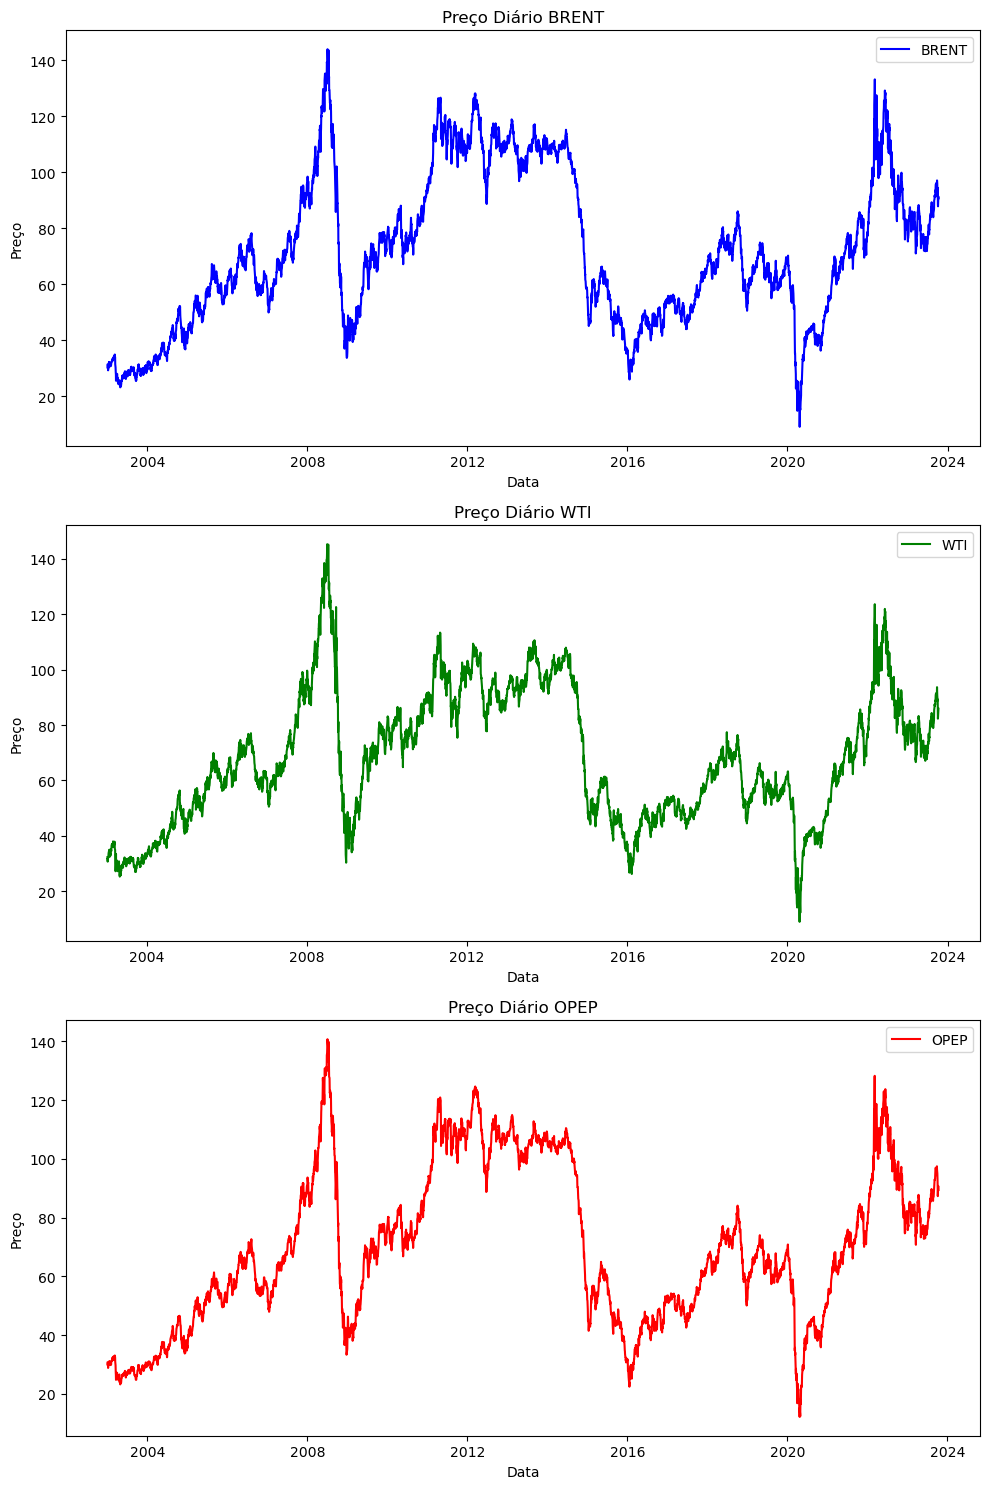

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = df_brent.toPandas()
df2 = df_wti.toPandas()
df3 = df_opep.toPandas()

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

axs[0].plot(df1['data'], df1['preco_brent'], label='BRENT', color='blue')
axs[0].set_title('Preço Diário BRENT')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Preço')
axs[0].legend()

axs[1].plot(df2['data'], df2['preco_wti'], label='WTI', color='green')
axs[1].set_title('Preço Diário WTI')
axs[1].set_xlabel('Data')
axs[1].set_ylabel('Preço')
axs[1].legend()

axs[2].plot(df3['data'], df3['preco_opep'], label='OPEP', color='red')
axs[2].set_title('Preço Diário OPEP')
axs[2].set_xlabel('Data')
axs[2].set_ylabel('Preço')
axs[2].legend()

plt.tight_layout()
plt.show()

No `BRLUSD.csv` temos as informações de data (yyyy-mm-dd) e preço do Dólar na abertura, máxima, mínima, fechamento e volume.

In [115]:
from pyspark.sql.types import StructType, StructField, StringType, DateType, DecimalType

"""
Amostra:

"Data","Último","Abertura","Máxima","Mínima","Vol.","Var%"
"13.10.2023","5,0807","5,0504","5,1024","5,0455","","0,66%"
"""

schema = StructType([
    StructField("Data", DateType(), True),
    StructField("Último", StringType(), True),
    StructField("Abertura", StringType(), True),
    StructField("Máxima", StringType(), True),
    StructField("Mínima", StringType(), True),
    StructField("Vol.", StringType(), True),
    StructField("Var%", StringType(), True)
])

df_csv = (
    spark.read.csv(f"{DATA_PATH}/crude-oil/BRLUSD.csv",
        header=True,
        schema=schema,
        dateFormat="dd.MM.yyyy")
    .withColumn("Último", F.regexp_replace(F.col("Último"), ',', '.').cast(DecimalType(6, 4)))
)

print(f"Records: {df_csv.count()}")

df_csv.show()

Records: 5420
+----------+------+--------+------+------+----+------+
|      Data|Último|Abertura|Máxima|Mínima|Vol.|  Var%|
+----------+------+--------+------+------+----+------+
|2023-10-13|5.0807|  5,0504|5,1024|5,0455|null| 0,66%|
|2023-10-12|5.0475|  5,0479|5,0479|5,0449|null|-0,02%|
|2023-10-11|5.0483|  5,0518|5,0714|5,0280|null|-0,07%|
|2023-10-10|5.0516|  5,1353|5,1400|5,0471|null|-1,63%|
|2023-10-09|5.1355|  5,1615|5,1820|5,1210|null|-0,20%|
|2023-10-06|5.1457|  5,1668|5,2210|5,1424|null|-0,39%|
|2023-10-05|5.1658|  5,1550|5,1884|5,1494|null| 0,19%|
|2023-10-04|5.1562|  5,1673|5,1789|5,1231|null|-0,21%|
|2023-10-03|5.1669|  5,0637|5,1739|5,0637|null| 2,09%|
|2023-10-02|5.0610|  5,0308|5,0810|5,0308|null| 0,58%|
|2023-09-29|5.0320|  5,0335|5,0406|4,9876|null|-0,02%|
|2023-09-28|5.0331|  5,0436|5,0702|5,0140|null|-0,19%|
|2023-09-27|5.0425|  4,9911|5,0800|4,9864|null| 1,06%|
|2023-09-26|4.9898|  4,9684|4,9942|4,9519|null| 0,44%|
|2023-09-25|4.9678|  4,9320|4,9759|4,9320|null| 0,6

In [116]:
from pyspark.sql import functions as F

df_brl_usd = (
    df_csv.select(
        F.column("Data").alias("data"),
        F.column("Último").alias("brl_usd")
    )
    .filter(F.col("brl_usd").isNotNull())
)

print(f"Records: {df_brl_usd.count()}")

df_brl_usd.write.mode("overwrite").saveAsTable("precos_mkt.brl_usd")

spark.sql("describe table precos_mkt.brl_usd").show()

Records: 5420


+--------+------------+-------+
|col_name|   data_type|comment|
+--------+------------+-------+
|    data|        date|   null|
| brl_usd|decimal(6,4)|   null|
+--------+------------+-------+



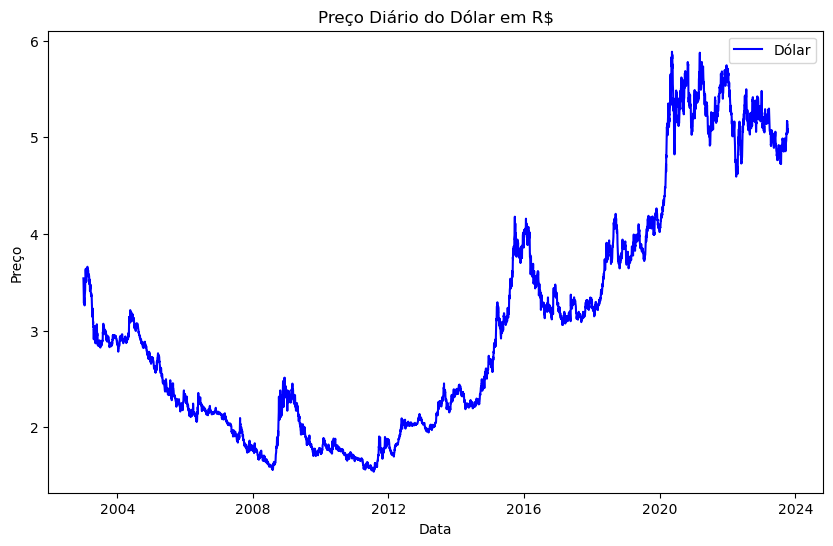

In [117]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = df_brl_usd.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(df1['data'], df1['brl_usd'], label='Dólar', color='blue')
plt.title('Preço Diário do Dólar em R$')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()

# Exibir o gráfico
plt.show()

## Analítico

Algumas perguntas para análise dos dados com consultas SQL de exemplo

### 1. Qual a distribuição de CNPJs por bandeira?

In [15]:
from pyspark.sql import functions as F

df_result = (
    spark.table('precos_anp.combustiveis_automotivos')
    .groupBy("bandeira")
    .agg(F.countDistinct("cnpj_revenda").alias("contagem"))
    .orderBy(F.desc("contagem"))
)

df_result.show()

+--------------------+--------+
|            bandeira|contagem|
+--------------------+--------+
|              BRANCA|   26021|
|PETROBRAS DISTRIB...|    9208|
|            IPIRANGA|    7126|
|              RAIZEN|    5819|
|                CBPI|    4033|
|       VIBRA ENERGIA|    3549|
| COSAN LUBRIFICANTES|    2395|
|              ALESAT|    1774|
|            LIQUIGÁS|     498|
|               SABBÁ|     484|
|            SATELITE|     463|
|    ALE COMBUSTÍVEIS|     428|
|                  SP|     415|
|                DPPI|     400|
|             ATEM' S|     232|
|             EQUADOR|     229|
|            PETROSUL|     214|
|               ASTER|     214|
|   TDC DISTRIBUIDORA|     204|
|              DISLUB|     187|
+--------------------+--------+
only showing top 20 rows



### 2. Qual o preço médio de revenda de combustíveis por mês, produto, estado?

Consideramos declarar criar uma tabela intermediária para facilitar o reuso em consultas subsequentes.

In [16]:
from pyspark.sql import functions as F

df_result = (
    spark.table('precos_anp.combustiveis_automotivos')
    .groupBy("mes", "regiao", "estado", "produto")
    .agg(F.avg("valor_venda").alias("valor_venda_medio"))
    .orderBy("mes", "regiao", "estado", "produto", ascending=[False, True, True, True])
)

df_result.write.mode("overwrite").saveAsTable("precos_anp.media_venda_combustiveis_automotivos")

+-------+------+------+------------------+-----------------+
|    mes|regiao|estado|           produto|valor_venda_medio|
+-------+------+------+------------------+-----------------+
|2023-06|    CO|    DF|            DIESEL|       5.01061728|
|2023-06|    CO|    DF|        DIESEL S10|       5.18187500|
|2023-06|    CO|    DF|            ETANOL|       3.83377049|
|2023-06|    CO|    DF|          GASOLINA|       5.42500000|
|2023-06|    CO|    DF|GASOLINA ADITIVADA|       5.50687151|
|2023-06|    CO|    DF|               GNV|       6.04000000|
|2023-06|    CO|    GO|            DIESEL|       4.90575058|
|2023-06|    CO|    GO|        DIESEL S10|       5.02353933|
|2023-06|    CO|    GO|            ETANOL|       3.75582880|
|2023-06|    CO|    GO|          GASOLINA|       5.35765730|
|2023-06|    CO|    GO|GASOLINA ADITIVADA|       5.48975000|
|2023-06|    CO|    MS|            DIESEL|       5.16706250|
|2023-06|    CO|    MS|        DIESEL S10|       5.22741758|
|2023-06|    CO|    MS| 

Fazendo uma comparação do preço médio da gasolina entre os estados, considerando o último mês da série (2023-06)

In [18]:
from pyspark.sql import functions as F

df_result = (
    spark.table('precos_anp.media_venda_combustiveis_automotivos')
    .select("regiao", "estado", "valor_venda_medio")
    .filter((F.col("mes") == '2023-06') & (F.col("produto") == 'GASOLINA'))
    .orderBy("valor_venda_medio", ascending=False)
)

df_result.show()

+------+------+-----------------+
|regiao|estado|valor_venda_medio|
+------+------+-----------------+
|     N|    AM|       6.19634855|
|     N|    AC|       6.09985915|
|     N|    RO|       5.91151899|
|     N|    RR|       5.74308824|
|    NE|    RN|       5.70969849|
|     N|    TO|       5.61351351|
|    SE|    ES|       5.58682464|
|    NE|    BA|       5.57350569|
|    NE|    AL|       5.55412556|
|     S|    SC|       5.54860000|
|     N|    PA|       5.48006865|
|     S|    PR|       5.44663198|
|    NE|    CE|       5.43531457|
|     S|    RS|       5.42974790|
|    CO|    DF|       5.42500000|
|    NE|    PE|       5.42040945|
|    CO|    MS|       5.41880597|
|    SE|    RJ|       5.41836054|
|    NE|    SE|       5.41771242|
|    CO|    MT|       5.39057692|
+------+------+-----------------+
only showing top 20 rows



Os dados indicam que os valores mais altos se concentram no norte do país.

### 3. Qual o preço médio de distribuição de combustíveis por mês, produto, estado?

Consideramos declarar uma tabela intermediária para facilitar o reuso em consultas subsequentes.

In [21]:
from pyspark.sql import functions as F

df_result = (
    spark.table('precos_anp.distribuicao_combustiveis')
    .groupBy("mes", "regiao", "estado", "produto")
    .agg(F.avg("preco_medio").alias("valor_distribuicao_medio"))
    .orderBy("mes", "regiao", "estado", "produto", ascending=[False, True, True, True])
)

df_result.write.mode("overwrite").saveAsTable("precos_anp.media_distribuicao_combustiveis_automotivos")

Fazendo uma comparação do preço médio de distribuição da gasolina entre os estados, considerando o último mês da série (2023-06)

In [22]:
from pyspark.sql import functions as F

df_result = (
    spark.table('precos_anp.media_distribuicao_combustiveis_automotivos')
    .select("regiao", "estado", "valor_distribuicao_medio")
    .filter((F.col("mes") == '2023-06') & (F.col("produto") == 'GASOLINA'))
    .orderBy("valor_distribuicao_medio", ascending=False)
)

df_result.show()

+------+------+------------------------+
|regiao|estado|valor_distribuicao_medio|
+------+------+------------------------+
|     N|    AC|              5.03100000|
|     N|    RR|              4.90800000|
|    SE|    ES|              4.87740000|
|    NE|    AL|              4.87720000|
|    NE|    CE|              4.86730769|
|     N|    AM|              4.86640000|
|    NE|    RN|              4.85850000|
|    CO|    MS|              4.85714286|
|    NE|    SE|              4.83850000|
|    CO|    MT|              4.82442857|
|     N|    RO|              4.82300000|
|     N|    AP|              4.80850000|
|     N|    PA|              4.80225000|
|    CO|    DF|              4.79400000|
|     N|    TO|              4.77160000|
|    NE|    BA|              4.77043333|
|    NE|    PI|              4.76750000|
|    NE|    PB|              4.72750000|
|    SE|    RJ|              4.72171875|
|     S|    SC|              4.72171429|
+------+------+------------------------+
only showing top

### 4. Qual o ágio médio entre os preços de revenda e distribuição de combustíveis por mês, produto, estado?

Combinamos as duas tabelas para calcular a razão preço de revenda / preço de distribuição.

Exemplo de execução para o preço da gasolina no último mês da série.

In [23]:
from pyspark.sql import functions as F

df_result = (
    spark.table("precos_anp.media_venda_combustiveis_automotivos").alias("v")
    .join(
        spark.table("precos_anp.media_distribuicao_combustiveis_automotivos").alias("d"),
        (F.col("v.mes") == F.col("d.mes")) & 
        (F.col("v.regiao") == F.col("d.regiao")) & 
        (F.col("v.estado") == F.col("d.estado")) & 
        (F.col("v.produto") == F.col("d.produto"))
    )
    .filter((F.col("v.mes") == '2023-06') & (F.col("v.produto") == 'GASOLINA'))
    .select(
        F.col("v.mes"), 
        F.col("v.regiao"), 
        F.col("v.estado"), 
        F.col("v.produto"),
        (F.col("v.valor_venda_medio") / F.col("d.valor_distribuicao_medio")).alias("agio_preco_medio")
    )
    .orderBy("agio_preco_medio", ascending=False)
)

df_result.show()

+-------+------+------+--------+--------------------+
|    mes|regiao|estado| produto|    agio_preco_medio|
+-------+------+------+--------+--------------------+
|2023-06|     N|    AM|GASOLINA|1.273292074223245...|
|2023-06|     N|    RO|GASOLINA|1.225693342318059...|
|2023-06|     N|    AC|GASOLINA|1.212454611409262...|
|2023-06|     N|    TO|GASOLINA|1.176442599966468...|
|2023-06|    NE|    RN|GASOLINA|1.175197795615930...|
|2023-06|     S|    SC|GASOLINA|1.175124045889697...|
|2023-06|     S|    PR|GASOLINA|1.172031398766201...|
|2023-06|     N|    RR|GASOLINA|1.170148378158109...|
|2023-06|    NE|    BA|GASOLINA|1.168343692165172...|
|2023-06|     S|    RS|GASOLINA|1.154487663521395...|
|2023-06|    SE|    SP|GASOLINA|1.154090416722058...|
|2023-06|    CO|    GO|GASOLINA|1.151659889770844...|
|2023-06|    NE|    PE|GASOLINA|1.149338792825854...|
|2023-06|    SE|    RJ|GASOLINA|1.147539874118931...|
|2023-06|    SE|    ES|GASOLINA|1.145451396235699...|
|2023-06|     N|    PA|GASOL

É interessante fazer uma análise histórica sobre esse ágio considerando agrupamento por regiões ou estados.

In [1]:
from pyspark.sql import functions as F

estado = "SP"
produto = "GASOLINA"

df_result = (
    spark.table("precos_anp.media_venda_combustiveis_automotivos").alias("v")
    .join(
        spark.table("precos_anp.media_distribuicao_combustiveis_automotivos").alias("d"),
        (F.col("v.mes") == F.col("d.mes")) & 
        (F.col("v.regiao") == F.col("d.regiao")) & 
        (F.col("v.estado") == F.col("d.estado")) & 
        (F.col("v.produto") == F.col("d.produto"))
    )
    .filter((F.col("v.produto") == produto) & (F.col("v.estado") == estado))
    .select(
        F.col("v.mes"), 
        (F.col("v.valor_venda_medio") / F.col("d.valor_distribuicao_medio")).alias("agio_preco_medio")
    )
    .orderBy("v.mes", ascending=True)
)

df_result.show()

ivysettings.xml file not found in HIVE_HOME or HIVE_CONF_DIR,/etc/hive/conf.dist/ivysettings.xml will be used


+-------+--------------------+
|    mes|    agio_preco_medio|
+-------+--------------------+
|2020-10|1.150007099734113...|
|2020-11|1.152860787993330...|
|2020-12|1.126473018809336...|
|2021-01|1.125017081361999...|
|2021-02|1.115024132449596...|
|2021-03|1.117989495200567...|
|2021-04|1.113066405631115...|
|2021-05|1.101153744581914...|
|2021-06|1.106134851537494...|
|2021-07|1.104985084423509...|
|2021-08|1.095304385282671...|
|2021-09|1.103102039372125...|
|2021-10|1.098855002288561...|
|2021-11|1.100613717756315...|
|2021-12|1.121438202001984...|
|2022-01|1.118152735802098...|
|2022-02|1.130970170524286...|
|2022-03|1.123902357718041...|
|2022-04|1.107694917376416...|
|2022-05|1.117499811280257...|
+-------+--------------------+
only showing top 20 rows



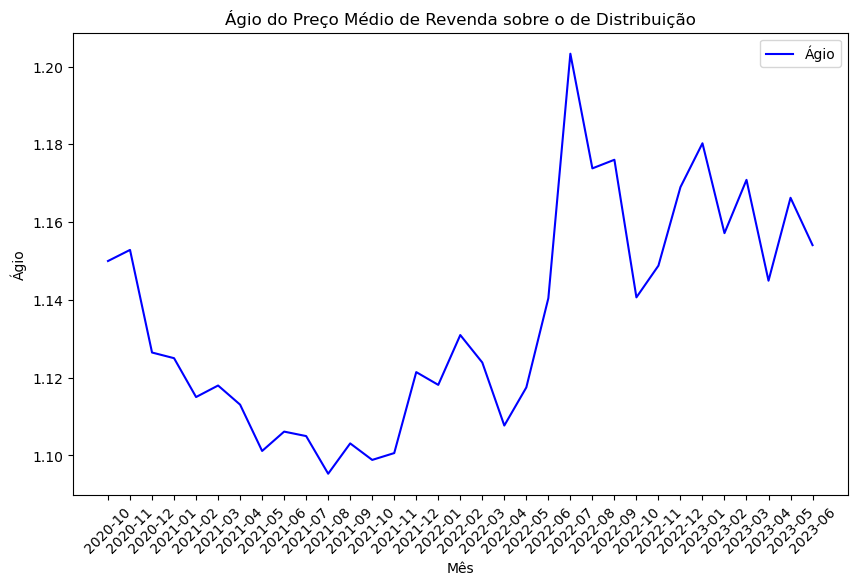

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = df_result.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(df1['mes'], df1['agio_preco_medio'], label='Ágio', color='blue')
plt.title('Ágio do Preço Médio de Revenda sobre o de Distribuição')
plt.xlabel('Mês')
plt.xticks(rotation=45)
plt.ylabel('Ágio')
plt.legend()

# Exibir o gráfico
plt.show()

### 5. Em quais estados é mais vantajoso abastecer o carro com etanol?

Diz-se que se o preço do etanol está menor do que 70% do preço da gasolina, é mais vantajoso abastecer com etanol.

Podemos então consultar a razão entre os preços médios de revenda do etanol e da gasolina.

In [27]:
df_gasolina = (
    spark.table("precos_anp.media_venda_combustiveis_automotivos")
    .filter(F.col("produto") == "GASOLINA")
)

df_etanol = (
    spark.table("precos_anp.media_venda_combustiveis_automotivos")
    .filter(F.col("produto") == "ETANOL")
)

df_result = (
    df_gasolina.alias("g")
    .join(
        df_etanol.alias("e"),
        (F.col("g.mes") == F.col("e.mes")) & 
        (F.col("g.regiao") == F.col("e.regiao")) & 
        (F.col("g.estado") == F.col("e.estado"))
    )
    .filter(F.col("g.mes") == '2023-06')
    .select(
        F.col("g.mes"), 
        F.col("g.regiao"), 
        F.col("g.estado"),
        (F.col("e.valor_venda_medio") / F.col("g.valor_venda_medio")).alias("razao_etanol_gasolina")
    )
    .orderBy("razao_etanol_gasolina", ascending=False)
)

df_result.show()

+-------+------+------+---------------------+
|    mes|regiao|estado|razao_etanol_gasolina|
+-------+------+------+---------------------+
|2023-06|     N|    AP| 1.030704033246293...|
|2023-06|     S|    RS| 0.885060910470631...|
|2023-06|     N|    RR| 0.881929684576812...|
|2023-06|    NE|    MA| 0.879345178385414...|
|2023-06|     N|    PA| 0.848628536797618...|
|2023-06|    NE|    CE| 0.837197902972522...|
|2023-06|     S|    SC| 0.833240311069458...|
|2023-06|     N|    RO| 0.832856064292199...|
|2023-06|    NE|    PI| 0.817529434254434...|
|2023-06|    NE|    RN| 0.816962007393143...|
|2023-06|    NE|    AL| 0.815443875201121...|
|2023-06|    NE|    SE| 0.811826172936658...|
|2023-06|     N|    TO| 0.807027796749704...|
|2023-06|    SE|    RJ| 0.799463174888690...|
|2023-06|    SE|    ES| 0.792597311592010...|
|2023-06|    NE|    PE| 0.791263065929456...|
|2023-06|    NE|    BA| 0.786031473487201...|
|2023-06|     N|    AC| 0.783112344487495...|
|2023-06|    NE|    PB| 0.78279891

### 6. Qual o comportamento do preço de revenda médio da GASOLINA na região SUDESTE em comparação com a região NORDESTE?

In [126]:
df_gasolina_se = (
    spark.table("precos_anp.combustiveis_automotivos")
    .filter((F.col("produto") == "GASOLINA") & (F.col("regiao") == "SE"))
    .groupBy("data")
    .agg(F.avg("valor_venda").alias("valor_medio_venda"))
    .orderBy("data")
)

df_gasolina_ne = (
    spark.table("precos_anp.combustiveis_automotivos")
    .filter((F.col("produto") == "GASOLINA") & (F.col("regiao") == "NE"))
    .groupBy("data")
    .agg(F.avg("valor_venda").alias("valor_medio_venda"))
    .orderBy("data")
)

+----------+-----------------+
|      data|valor_medio_venda|
+----------+-----------------+
|2004-05-10|       1.92404812|
|2004-05-11|       1.91125529|
|2004-05-12|       1.90784185|
|2004-05-13|       1.83328440|
|2004-05-17|       1.90914577|
|2004-05-18|       1.91524624|
|2004-05-19|       1.89942051|
|2004-05-20|       1.92943787|
|2004-05-24|       1.91682513|
|2004-05-25|       1.92696548|
|2004-05-26|       1.89062986|
|2004-05-27|       1.87995000|
|2004-05-31|       1.93655337|
|2004-06-01|       1.95041653|
|2004-06-02|       1.90784265|
|2004-06-03|       1.95629091|
|2004-06-07|       1.95441750|
|2004-06-08|       1.95231322|
|2004-06-09|       1.89326468|
|2004-06-11|       1.93968085|
+----------+-----------------+
only showing top 20 rows



+----------+-----------------+
|      data|valor_medio_venda|
+----------+-----------------+
|2004-05-10|       2.04432939|
|2004-05-11|       2.03250987|
|2004-05-12|       2.02748284|
|2004-05-13|       2.05000000|
|2004-05-17|       2.00953713|
|2004-05-18|       2.03606652|
|2004-05-19|       2.07477228|
|2004-05-20|       2.08923077|
|2004-05-24|       2.02714405|
|2004-05-25|       2.00292015|
|2004-05-26|       2.03609496|
|2004-05-27|       2.03475000|
|2004-05-31|       2.01966794|
|2004-06-01|       2.00013178|
|2004-06-02|       2.03450595|
|2004-06-03|       2.12000000|
|2004-06-07|       2.04772404|
|2004-06-08|       2.04969414|
|2004-06-09|       2.07195556|
|2004-06-11|       1.96355172|
+----------+-----------------+
only showing top 20 rows



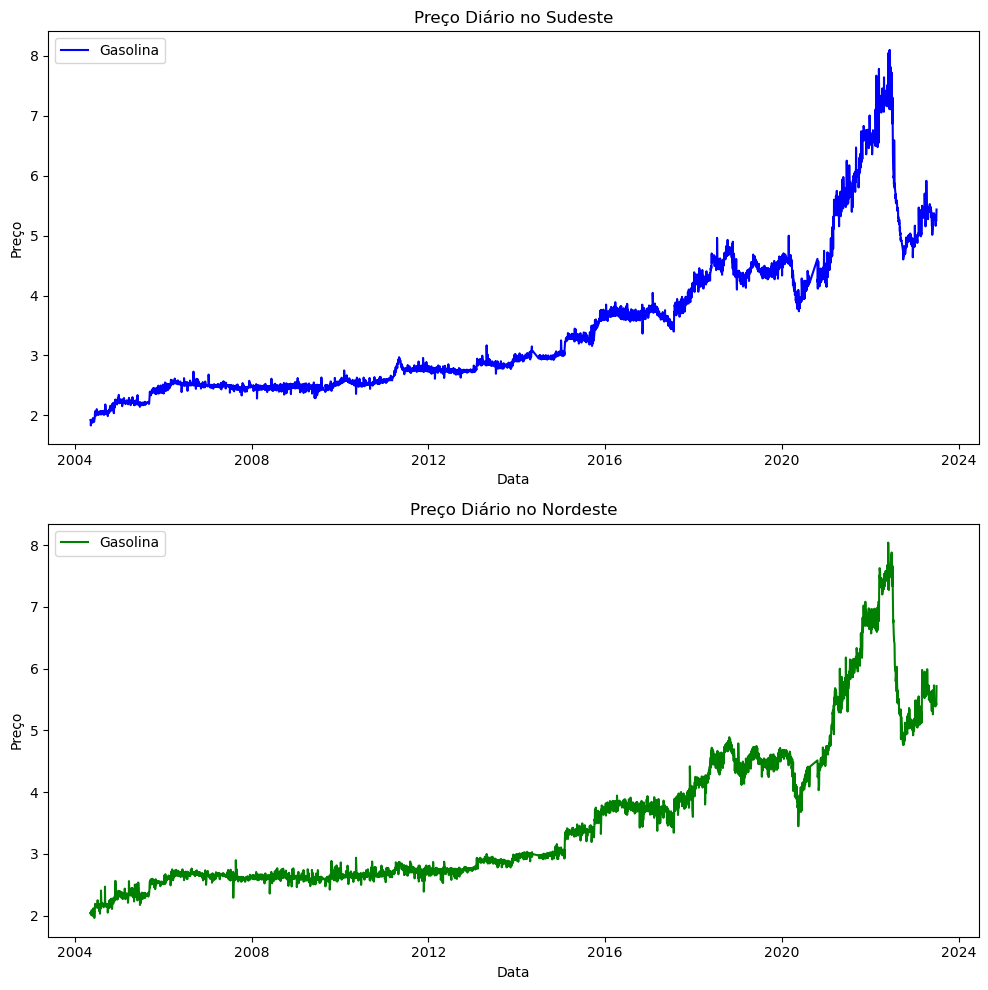

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = df_gasolina_se.toPandas()
df2 = df_gasolina_ne.toPandas()

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(df1['data'], df1['valor_medio_venda'], label='Gasolina', color='blue')
axs[0].set_title('Preço Diário no Sudeste')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Preço')
axs[0].legend()

axs[1].plot(df2['data'], df2['valor_medio_venda'], label='Gasolina', color='green')
axs[1].set_title('Preço Diário no Nordeste')
axs[1].set_xlabel('Data')
axs[1].set_ylabel('Preço')
axs[1].legend()

plt.tight_layout()
plt.show()

Verificando a relação de preço entre Sudeste e Nordeste

In [136]:
df_razao = (
    df_gasolina_se.alias("se").join(
        df_gasolina_ne.alias("ne"), (F.col("se.data") == F.col("ne.data"))
    )
    .select(F.col("se.data").alias("data"), (F.col("ne.valor_medio_venda") / F.col("se.valor_medio_venda")).alias("razao_preco_medio"))
    .orderBy("data")
)

In [137]:
df_razao.show()

+----------+--------------------+
|      data|   razao_preco_medio|
+----------+--------------------+
|2004-05-10|1.062514689081684...|
|2004-05-11|1.063442377705596...|
|2004-05-12|1.062710119290023...|
|2004-05-13|1.118211664267693...|
|2004-05-17|1.052584439374684...|
|2004-05-18|1.063083418453806...|
|2004-05-19|1.092318561938662...|
|2004-05-20|1.082818370305958...|
|2004-05-24|1.057552939114482...|
|2004-05-25|1.039416725825311...|
|2004-05-26|1.076940020401454...|
|2004-05-27|1.082342615495092...|
|2004-05-31|1.042918811992256...|
|2004-06-01|1.025489555300272...|
|2004-06-02|1.066390852516060...|
|2004-06-03|1.083683407801552...|
|2004-06-07|1.047741355160808...|
|2004-06-08|1.049879762633579...|
|2004-06-09|1.094382408274790...|
|2004-06-11|1.012306596726982...|
+----------+--------------------+
only showing top 20 rows



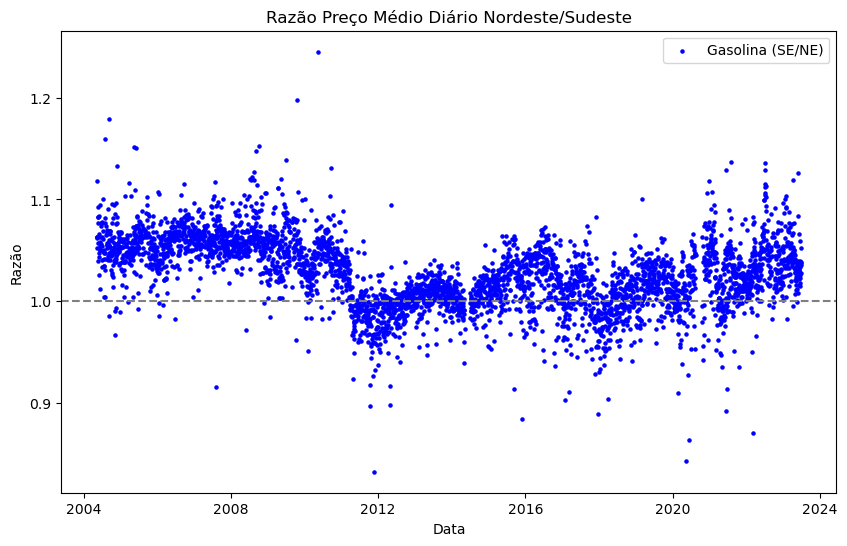

In [142]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = df_razao.toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(df1['data'], df1['razao_preco_medio'], label='Gasolina (SE/NE)', color='blue', s=5)
plt.axhline(y=1.0, color='gray', linestyle='--')
plt.title('Razão Preço Médio Diário Nordeste/Sudeste')
plt.xlabel('Data')
plt.ylabel('Razão')
plt.legend()

# Exibir o gráfico
plt.show()

Antes de 2012 o preço da gasolina no Nordeste era visivelmente mais alto do que no Sudeste.

Observamos que entre 2011 e 2012 o preço da gasolina no Sudeste teve uma alta que não foi acompanhada pelo preço no Nordeste.

Desde então temos algumas variações sazonais nessa razão de preços que podem ser explicadas por variações na oferta e demanda ou alterações na tributação.

## Trabalhos futuros

- Incluir na análise dados sobre tributação de combustíveis (tributações federais e estaduais)
- Gerar comprações entre os preços dos combustíveis com preços do Petróleo no Mercado Internacional e Dólar.
- Comparar com dados de componentes da inflação tais como transporte e alimentação.